In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import warnings

np.random.seed(2023)
warnings.filterwarnings(action='ignore')

In [3]:
data = pd.read_csv('../../data/baseline_df.csv')


In [4]:
with open('../../data/baseline_feats.pkl', 'rb') as f:
    features = pickle.load(f)

- 전체 학습 데이터 기간 : 2015.1.28 ~ 2016.5.28
- 테스트 데이터 기간 : 2015. 6.28
- 훈련 데이터 기간 : 2016.1.28 ~ 2016.4.28
- 검증 데이터 : 2016. 5. 28


In [5]:
use_dates = ['2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28']

train = data[data['fecha_dato'].isin(use_dates)]
test = data[data['fecha_dato']=='2016-06-28']

del data

In [6]:
prods = [col for col in train.columns if ('ult1' in col) and ('_prev'not in col)]
len(prods)

24

In [7]:
np.zeros(9)+10

array([10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [7]:
## 신규 구매건 추출 (이전달 0 -> 현재달 1)

X = []
y = []

for i, prod in enumerate(prods):
    prev = prod + '_prev'
    X_prev = train[(train[prod]==1) & (train[prev]==0)]
    print(X_prev.shape)
    y_prev = np.zeros(X_prev.shape[0], dtype=np.int8)+i # 신규 구매 상품의 인덱스 
    X.append(X_prev)
    y.append(y_prev)
    

(1, 104)
(1, 104)
(33164, 104)
(37, 104)
(11725, 104)
(424, 104)
(4409, 104)
(1167, 104)
(713, 104)
(1, 104)
(0, 104)
(1578, 104)
(11549, 104)
(467, 104)
(18, 104)
(226, 104)
(32, 104)
(2316, 104)
(20443, 104)
(1550, 104)
(18, 104)
(26392, 104)
(30761, 104)
(52042, 104)


In [8]:
X_prev.shape

(52042, 104)

In [9]:
XY = pd.concat(X)


In [10]:
XY['y'] = np.hstack(y)


In [11]:
XY.head(10)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_valo_fin_ult1_prev,ind_viv_fin_ult1_prev,ind_nomina_ult1_prev,ind_nom_pens_ult1_prev,ind_recibo_ult1_prev,apply_month_prev,apply_year_prev,last_1_month_prev,last_1_year_prev,y
10597872,2016-05-28,194160,0,0,0,42,2000-09-25,0.0,-68,1.0,...,0.0,0.0,0.0,0.0,0.0,9.0,2000.0,0.0,0.0,0
7658069,2016-01-28,1474324,0,0,1,43,2015-10-09,1.0,3,1.0,...,0.0,0.0,0.0,0.0,1.0,10.0,2015.0,0.0,0.0,1
7628180,2016-01-28,1432311,0,0,1,26,2015-08-07,1.0,5,1.0,...,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,-99.0,-99.0,2
7628198,2016-01-28,1432232,0,0,1,33,2015-08-07,0.0,19,1.0,...,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,-99.0,-99.0,2
7628482,2016-01-28,1432080,0,0,0,23,2015-08-07,1.0,5,1.0,...,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,-99.0,-99.0,2
7628692,2016-01-28,1432952,0,0,0,77,2015-08-10,1.0,5,1.0,...,1.0,0.0,0.0,0.0,0.0,8.0,2015.0,0.0,0.0,2
7628745,2016-01-28,1432622,0,0,1,21,2015-08-10,1.0,5,1.0,...,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,-99.0,-99.0,2
7628799,2016-01-28,1432527,0,0,1,37,2015-08-10,1.0,5,1.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2015.0,0.0,0.0,2
7629388,2016-01-28,1431702,0,0,1,21,2015-08-07,0.0,19,1.0,...,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,-99.0,-99.0,2
7630481,2016-01-28,1433409,0,0,1,38,2015-08-10,1.0,5,1.0,...,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,-99.0,-99.0,2


* 고객 정보는 중복되었을 수도 있다.
* 각 경우에 따라 어떤 제품을 신규 구매있는지 y에 제품 인덱스를 담았다.  

In [12]:
XY['ncodpers'].duplicated().sum() # 중복된 고객 수

83154

## 데이터 분할

In [13]:
valid_date = '2016-05-28'

train_XY = XY[XY['fecha_dato'] != valid_date]
valid_XY = XY[XY['fecha_dato'] == valid_date]

# 학습

### XGBoost

- max_depth : 트리 모델의 최대 깊이. 높을수록 복잡하며 과적합 위험
- eta : 딥러닝의 learning rate와 유사. 0~1. 높을수록 학습이 잘 되지 않을 수 있고, 낮을 수록 학습이 느릴 수 있음
- colsample_bytree : 트리 생성 시, 훈련 데이터에서 변수 샘플링 비율. (0.6~0.9)
- colsample_bylevel : 트리 레벨 별로 훈련 데이터 변수 샘플 (0.6 ~ 0.9)

In [23]:
params = {
    'booster': 'gbtree',
    'max_depth': 8,
    'nthread': 4, 
    'num_class': len(prods), # 각 제품별로 구매 확률을 구하기 위해
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'min_child_weight': 10,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.9,
    'seed': 2023
}

train_x_mt = train_XY[features].to_numpy()
train_y_mt = train_XY['y'].to_numpy()
dtrain = xgb.DMatrix(train_x_mt, label=train_y_mt, feature_names=features)

valid_x_mt = valid_XY[features].to_numpy()
valid_y_mt = valid_XY['y'].to_numpy()
dvalid = xgb.DMatrix(valid_x_mt, label=valid_y_mt, feature_names=features)



In [53]:
watch_list = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params,
                  dtrain,
                  num_boost_round=1000,
                  evals=watch_list,
                 early_stopping_rounds=20)

[0]	train-mlogloss:2.72100	valid-mlogloss:2.74117
[1]	train-mlogloss:2.46495	valid-mlogloss:2.48488
[2]	train-mlogloss:2.28071	valid-mlogloss:2.30150
[3]	train-mlogloss:2.14389	valid-mlogloss:2.16548
[4]	train-mlogloss:2.03141	valid-mlogloss:2.05347
[5]	train-mlogloss:1.93588	valid-mlogloss:1.95816
[6]	train-mlogloss:1.85489	valid-mlogloss:1.87722
[7]	train-mlogloss:1.78508	valid-mlogloss:1.80790
[8]	train-mlogloss:1.72404	valid-mlogloss:1.74674
[9]	train-mlogloss:1.67186	valid-mlogloss:1.69493
[10]	train-mlogloss:1.62422	valid-mlogloss:1.64727
[11]	train-mlogloss:1.58158	valid-mlogloss:1.60512
[12]	train-mlogloss:1.54326	valid-mlogloss:1.56696
[13]	train-mlogloss:1.50749	valid-mlogloss:1.53150
[14]	train-mlogloss:1.47471	valid-mlogloss:1.49862
[15]	train-mlogloss:1.44610	valid-mlogloss:1.47015
[16]	train-mlogloss:1.41849	valid-mlogloss:1.44272
[17]	train-mlogloss:1.39445	valid-mlogloss:1.41881
[18]	train-mlogloss:1.37251	valid-mlogloss:1.39702
[19]	train-mlogloss:1.35155	valid-mloglos

[160]	train-mlogloss:0.99981	valid-mlogloss:1.08729
[161]	train-mlogloss:0.99909	valid-mlogloss:1.08717
[162]	train-mlogloss:0.99861	valid-mlogloss:1.08715
[163]	train-mlogloss:0.99801	valid-mlogloss:1.08708
[164]	train-mlogloss:0.99736	valid-mlogloss:1.08707
[165]	train-mlogloss:0.99677	valid-mlogloss:1.08704
[166]	train-mlogloss:0.99625	valid-mlogloss:1.08700
[167]	train-mlogloss:0.99570	valid-mlogloss:1.08699
[168]	train-mlogloss:0.99524	valid-mlogloss:1.08697
[169]	train-mlogloss:0.99479	valid-mlogloss:1.08692
[170]	train-mlogloss:0.99415	valid-mlogloss:1.08692
[171]	train-mlogloss:0.99358	valid-mlogloss:1.08686
[172]	train-mlogloss:0.99306	valid-mlogloss:1.08678
[173]	train-mlogloss:0.99256	valid-mlogloss:1.08681
[174]	train-mlogloss:0.99213	valid-mlogloss:1.08679
[175]	train-mlogloss:0.99168	valid-mlogloss:1.08677
[176]	train-mlogloss:0.99120	valid-mlogloss:1.08672
[177]	train-mlogloss:0.99069	valid-mlogloss:1.08670
[178]	train-mlogloss:0.99005	valid-mlogloss:1.08666
[179]	train-

In [55]:
model

In [57]:
## 모델 저장
with open('../../model/xgb_baseline.pkl', 'wb') as f:
    pickle.dump(model, f)
best_ntree_limit = model.best_ntree_limit


224

### Cross-validation

  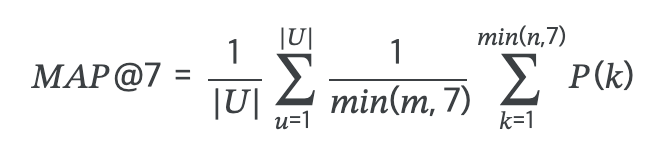

- |U| : 열의 개수 (두 개 시간 포인트에 대한 사용자)
- P(k) : cutoff k에 대한 precisionn
- n : 예측한 제품 개수
- m : 특정 시간에 주어진 사용자에 대한 추가된 제품의 개수
 (만약 m=0 이라면 precision은 0)

#### Mean Average Precision 
- 평균 정밀도. 검색 알고리즘이나 객체 검출 알고리즘 성능평가 지표 중 하나
    - 정밀도:  검색 결과 중에서 관련이 높은 결과의 비율
    - 재현율: 관련성이 높은 결과 중에서 검색된 결과의 비율
    - 계산 순서 
        1. 각 관측치에 대해 관련 높은 항목 순위를 매김
        2. 상위 k개를 선택하여 관련이 높은 결과의 정밀도 구함
        3. 모든 관측치에 대해 정밀도의 평균을 구함



In [14]:
# 고객 식별번호 추출
valid = train[train['fecha_dato']==valid_date]
code_valid = valid['ncodpers'].to_numpy()

In [15]:
# 검증 데이터에서 신규 구매 변수 생성

for prod in prods:
    prev = prod + '_prev'
    prod_add = prod + '_add'
    valid[prod_add] = valid[prod] - valid[prev]
    

In [16]:

valid_mat = valid[[p+'_add' for p in prods]].to_numpy()

In [17]:
valid_add_list = [list() for i in range(len(code_valid))]


In [18]:
# 검증 데이터의 고객 별 신규 구매 제품 인덱스 추가
count_valid = 0
for ncodper in range(len(code_valid)):
    for prod in range(len(prods)):
        if valid_mat[ncodper, prod] > 0:
            valid_add_list[ncodper].append(prod)
            count_valid += 1
            

In [20]:

def apk(actual, predicted, k=7, default=0.0):
    # MAP@7 이므로, 최대 7개만 사용한다
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        # 점수를 부여하는 조건은 다음과 같다 :
        # 예측값이 정답에 있고 (‘p in actual’)
        # 예측값이 중복이 아니면 (‘p not in predicted[:i]’) 
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # 정답값이 공백일 경우, 무조건 0.0점을 반환한다
    if not actual:
        return default

    # 정답의 개수(len(actual))로 average precision을 구한다
    return score / min(len(actual), k)

def mapk(actual, predicted, k=7, default=0.0):
    # list of list인 정답값(actual)과 예측값(predicted)에서 고객별 Average Precision을 구하고, np.mean()을 통해 평균을 계산한다
    return np.mean([apk(a, p, k, default) for a, p in zip(actual, predicted)]) 


In [21]:
# MAP@7는 최고 점수가 데이터에 따라 변할 수 있음 . 신규 구매를 하지 않으면 0이기 떄문
# 검증 데이터로 얻을 수 있는 최고 점수는 0.042663

print(mapk(valid_add_list, valid_add_list, 7, 0.0))

0.04266379915553903


In [27]:
# 모델 로드
with open('../../model/xgb_baseline.pkl', 'rb') as f:
    model = pickle.load(f)
best_ntree_limit = model.best_ntree_limit


In [28]:

# 예측 수행
valid_pred = model.predict(dvalid, ntree_limit=best_ntree_limit)

In [ ]:
valid_pred

In [ ]:
# 이전달에 가지고 있는 제품은 신규 구매가 아니기 때문에 1값을 뺌
valid_pred = valid_pred - valid_XY[[p+'_prev' for p in prods]].to_numpy()

In [105]:
# 이전달에 가지고 있는 제품은 신규 구매가 아니기 때문에 1값을 뺌
valid_pred = valid_pred - valid_XY[[p+'_prev' for p in prods]].to_numpy()

In [111]:
# 예측 상위 7개 추출
valid_result = []
for ncodper, pred in zip(code_valid, valid_pred):
    y_prods = [(y, p, ip) for y, p, ip in zip(pred, prods, range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda x:x[0], reverse=True)[:7]
    valid_result.append([ip for y, p, ip in y_prods])

In [114]:
print(mapk(valid_add_list, valid_result, 7, 0.0))

0.012782883513416271


In [112]:
valid_add_list

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [23],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [23],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [23],
 [],
 [],
 [],
 [],
 [23],
 [],
 [23],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [4],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [

In [113]:
valid_result

[[23, 22, 21, 18, 12, 17, 2],
 [18, 12, 2, 17, 7, 19, 11],
 [2, 23, 4, 12, 6, 21, 22],
 [12, 2, 18, 4, 11, 22, 23],
 [2, 6, 17, 4, 22, 21, 12],
 [2, 12, 11, 18, 22, 21, 23],
 [2, 4, 22, 21, 18, 17, 11],
 [2, 23, 21, 22, 4, 12, 18],
 [2, 6, 4, 17, 11, 23, 21],
 [2, 4, 22, 21, 12, 7, 17],
 [2, 4, 22, 21, 18, 12, 7],
 [2, 6, 22, 23, 21, 4, 12],
 [2, 4, 21, 22, 8, 18, 7],
 [2, 18, 12, 4, 23, 21, 22],
 [2, 23, 4, 22, 21, 6, 12],
 [4, 23, 18, 2, 8, 7, 17],
 [2, 6, 23, 4, 12, 22, 21],
 [2, 12, 18, 23, 7, 22, 4],
 [2, 6, 17, 11, 4, 21, 23],
 [2, 18, 12, 4, 23, 22, 11],
 [2, 11, 12, 18, 4, 6, 23],
 [2, 12, 23, 4, 18, 21, 22],
 [2, 4, 18, 21, 22, 12, 17],
 [2, 12, 23, 4, 22, 21, 18],
 [2, 23, 4, 18, 22, 21, 7],
 [2, 6, 4, 23, 12, 17, 21],
 [22, 21, 17, 19, 7, 2, 8],
 [2, 6, 23, 21, 4, 22, 12],
 [2, 23, 22, 21, 4, 18, 19],
 [2, 6, 11, 4, 21, 23, 12],
 [2, 4, 22, 21, 18, 8, 19],
 [2, 23, 18, 4, 22, 21, 12],
 [2, 23, 18, 12, 4, 22, 21],
 [2, 17, 4, 6, 23, 22, 21],
 [2, 6, 17, 11, 4, 21, 12],
 [4, 2